# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook I demonstrate traffic sign classification with a convolutional neural network coupled with image pre-processing. Training/validation/test imagery comes from a provided collection of German traffic signs and samples obtained via Google Street View in/around Düsseldorf and Hamburg.

I emphasized neural network structure/hyperparameter evaluation over image pre-processing techniques.

---
## Step 0: Load Provided Images

Loads training, validation, and test images from pickle files (serialized Python data).

In [1]:
import pickle

# Load training, validation, and test datasets via pickle.
training_file = 'input_data/train.p'
validation_file='input_data/valid.p'
testing_file = 'input_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Map to convenient globals
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Check dimension assumptions
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))


---

## Step 1: Summarize Images

Prints text summaries of dataset and individual image dimensions.

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape_raw = X_train[0].shape
arr_shape_raw = X_train.shape

# How many unique classes/labels there are in the dataset?
set_classes = set(y_train)
n_classes = len(set_classes)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape_raw)
print("Array data shape =", arr_shape_raw)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Array data shape = (34799, 32, 32, 3)
Number of classes = 43


---
## Step 2: Analyze / Display Images

Plot label distribution and samples of each label.

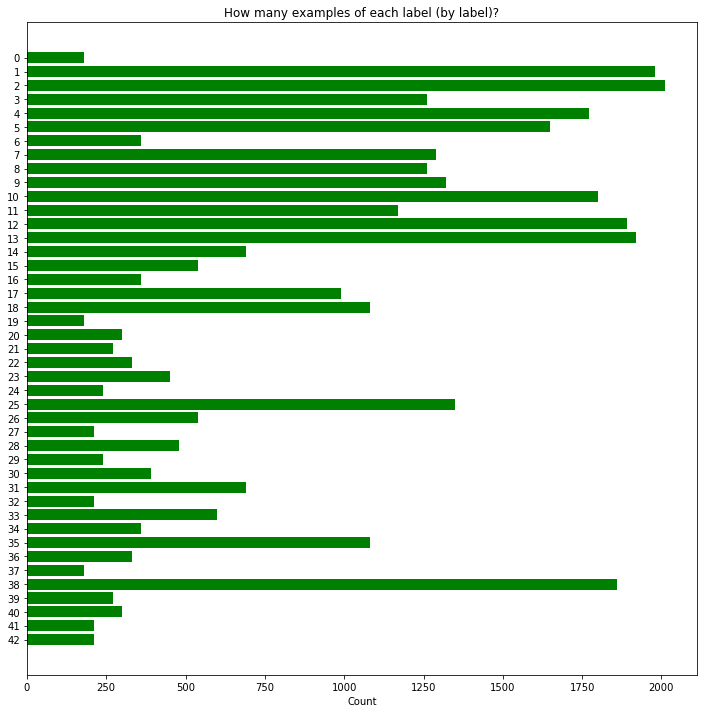

Examples of each label (raw):


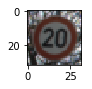

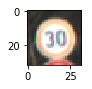

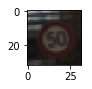

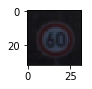

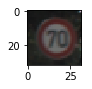

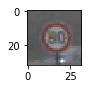

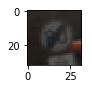

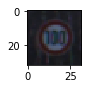

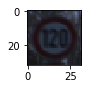

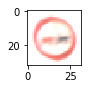

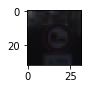

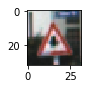

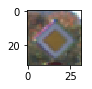

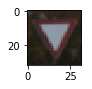

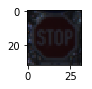

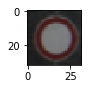

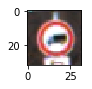

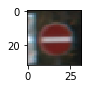

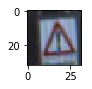

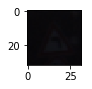

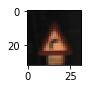

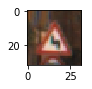

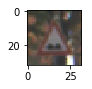

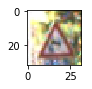

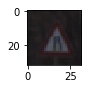

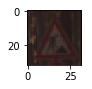

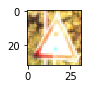

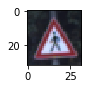

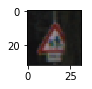

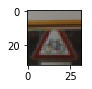

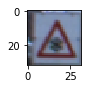

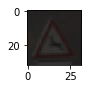

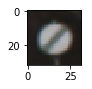

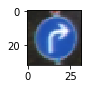

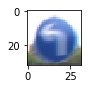

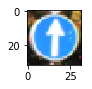

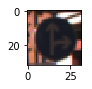

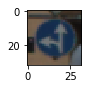

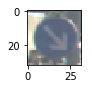

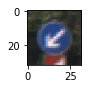

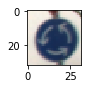

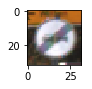

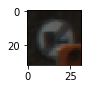

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Visualizations will be shown in the notebook.
%matplotlib inline

# (1) Map labels/images
dict_train_raw = defaultdict(list)
for key, value in zip(y_train,X_train):
    dict_train_raw[key].append(value)
  
# plt.rcdefaults()
plt.rcParams['figure.max_open_warning'] = 0

# (2) Count & plot distribution (in order)
train_labels = list(dict_train_raw.keys())
train_counts = list(len(value) for value in dict_train_raw.values())

fig,ax = plt.subplots(figsize=(12, 12))
ax.barh(train_labels, train_counts, align='center',
        color='green', ecolor='black')
ax.set_yticks(train_labels)
ax.set_yticklabels(train_labels)
ax.invert_yaxis()
ax.set_xlabel('Count')
ax.set_title('How many examples of each label (by label)?')

plt.show()

# (3) Plot examples
print ("Examples of each label (raw):")
for key, value in dict_train_raw.items():
    index = random.randint(0, (len(value)-1))
    image = value[index].squeeze()

    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap="gray")


---
## Step 3: Pre-Process / Display Images

Simple grayscale and/or normalization pre-processing step to (a) constrain training/validation permutations and (b) help me emphasize network structure and hyperparameters.

In [4]:
def pre_process_images(X_input,curr_grayscale,curr_normalize):
    """ Per-image pre-processing.
    """
    X_output = np.copy(X_input)
    
    # grayscale image
    if curr_grayscale:
        X_output = np.dot(X_output[...,:3], [0.299, 0.587, 0.114])
        X_output = np.expand_dims(X_output,axis=3)

    # noramlize pixels
    if curr_normalize:
        X_output = (X_output - 128.0)/128.0

    return X_output

In [5]:
def build_images(X_train,X_valid,X_test,curr_grayscale,curr_normalize):
    """ Pre-processing for training/validation/test sets.
    """
    # build images
    X_train_pre = pre_process_images(X_train,curr_grayscale,curr_normalize)    
    X_valid_pre = pre_process_images(X_valid,curr_grayscale,curr_normalize)
    X_test_pre = pre_process_images(X_test,curr_grayscale,curr_normalize)
    
    # build metrics
    image_shape_pre = X_train_pre[0].shape
    image_depth_pre = image_shape_pre[2]
    image_width = image_shape_pre[0]
    image_height = image_shape_pre[1]    
    
    return X_train_pre, X_valid_pre, X_test_pre, image_depth_pre, image_width, image_height

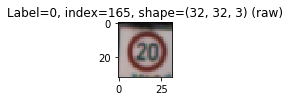

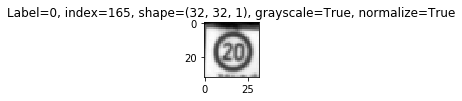

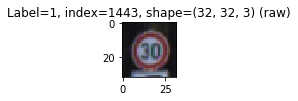

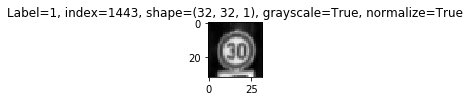

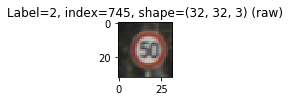

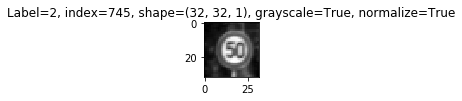

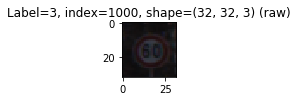

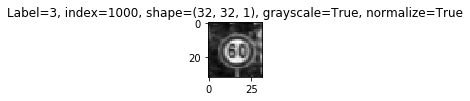

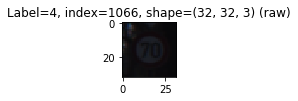

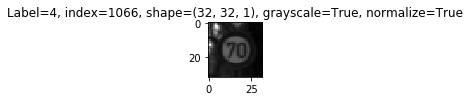

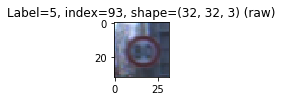

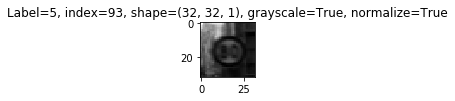

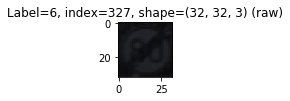

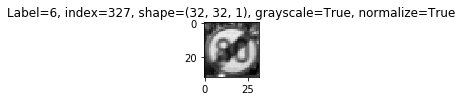

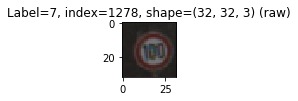

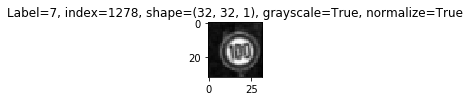

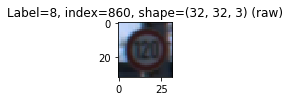

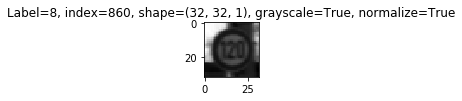

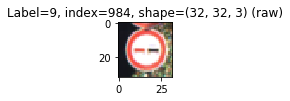

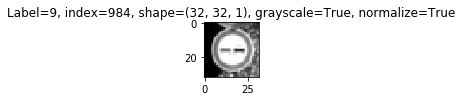

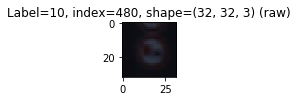

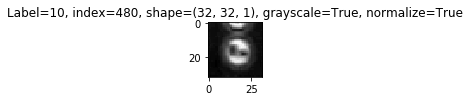

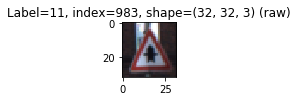

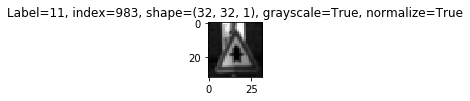

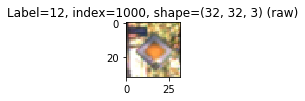

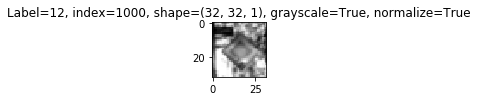

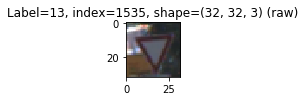

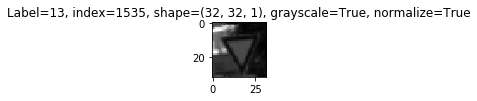

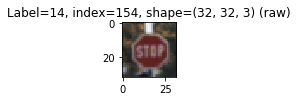

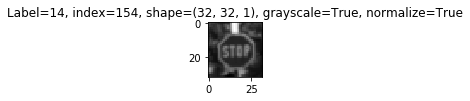

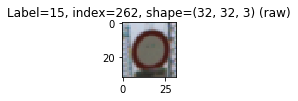

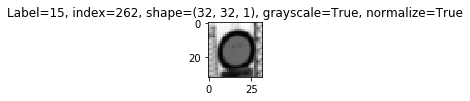

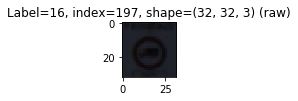

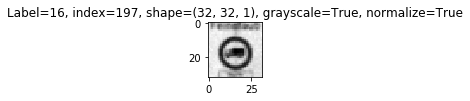

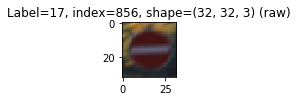

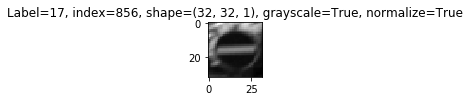

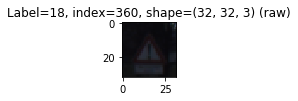

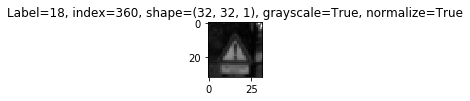

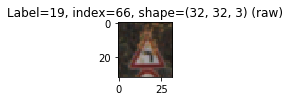

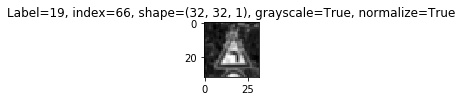

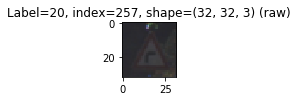

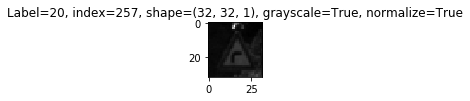

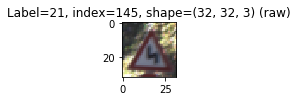

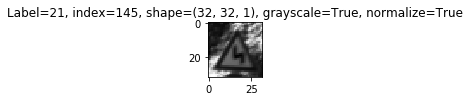

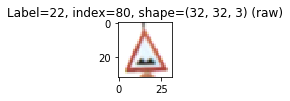

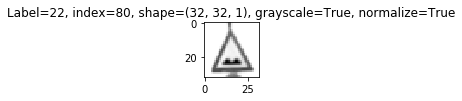

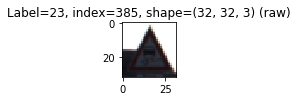

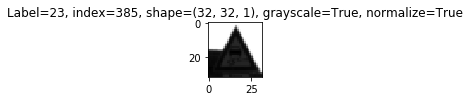

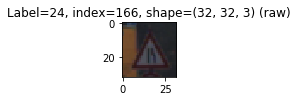

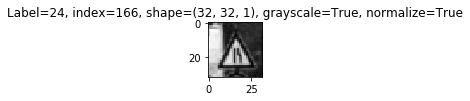

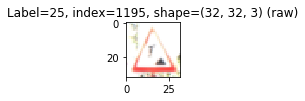

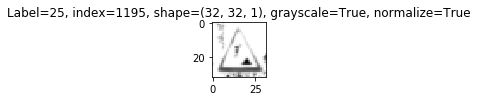

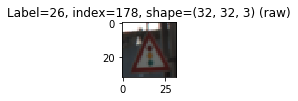

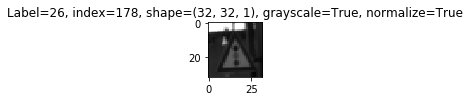

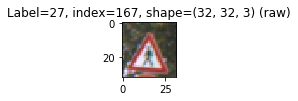

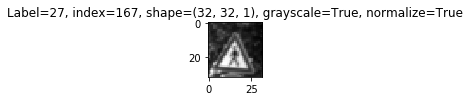

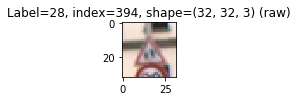

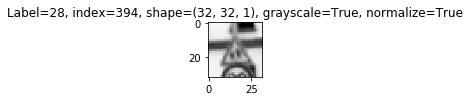

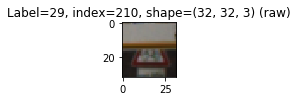

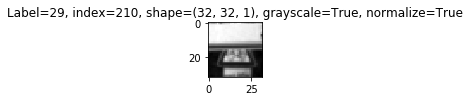

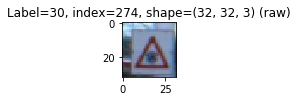

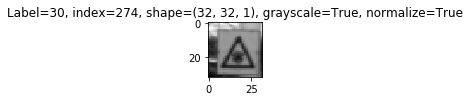

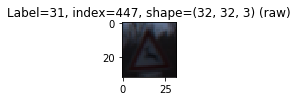

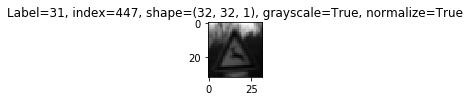

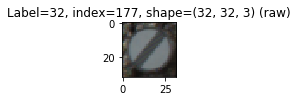

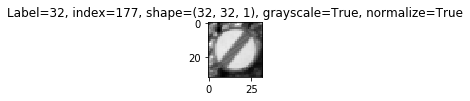

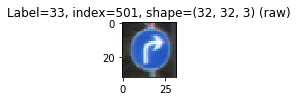

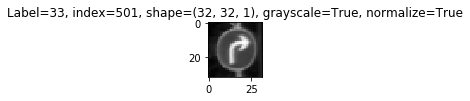

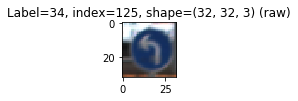

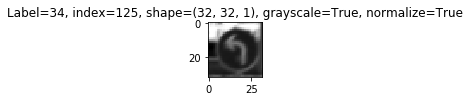

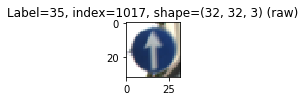

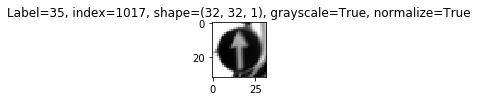

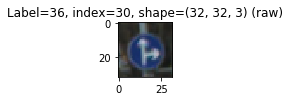

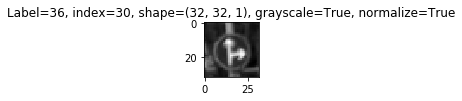

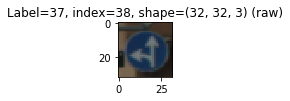

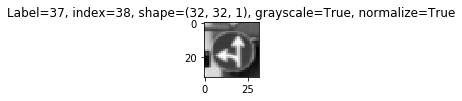

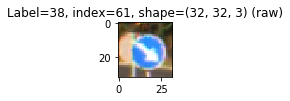

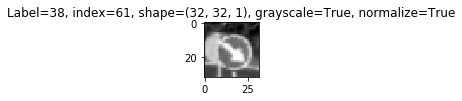

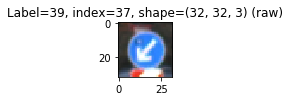

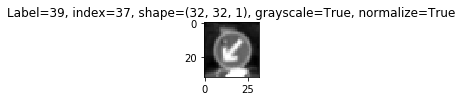

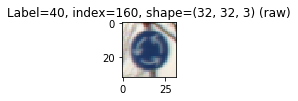

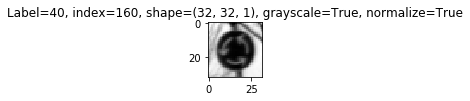

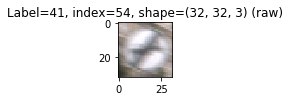

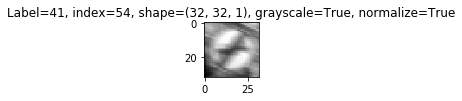

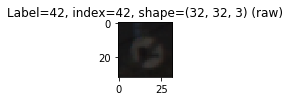

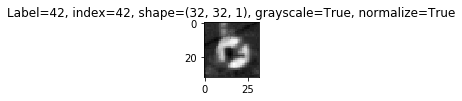

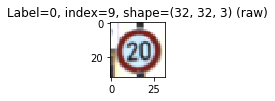

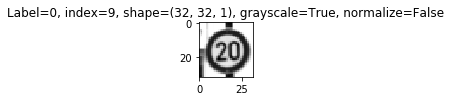

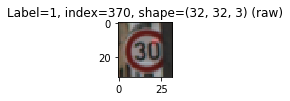

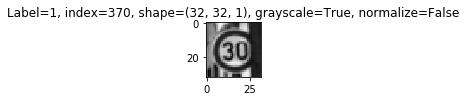

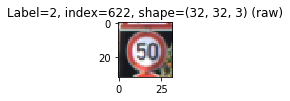

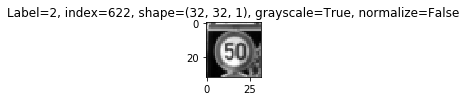

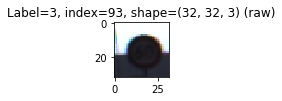

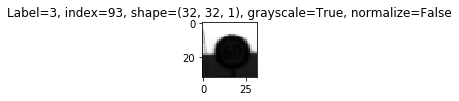

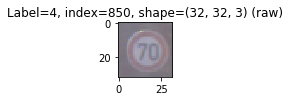

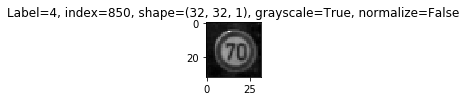

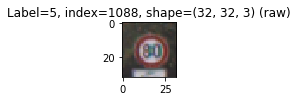

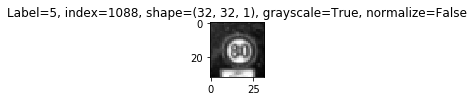

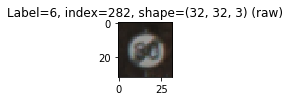

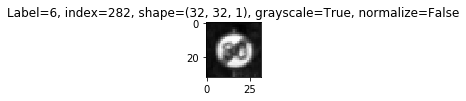

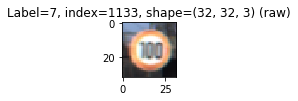

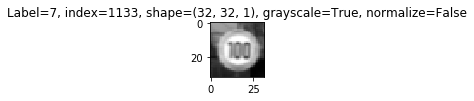

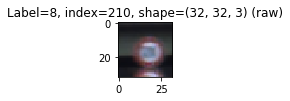

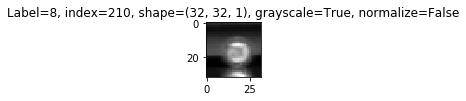

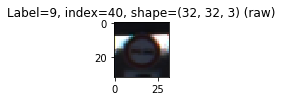

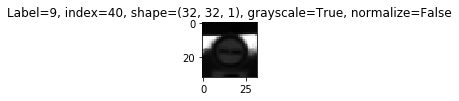

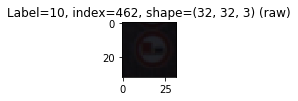

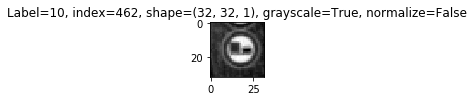

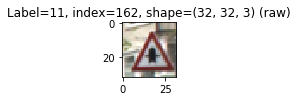

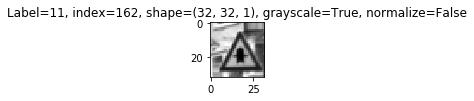

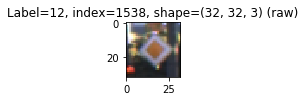

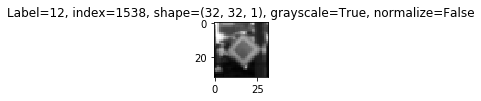

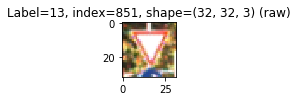

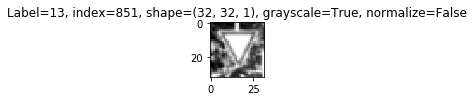

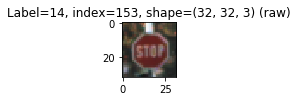

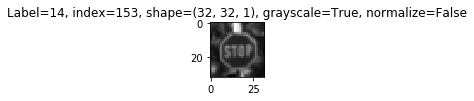

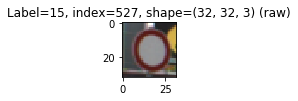

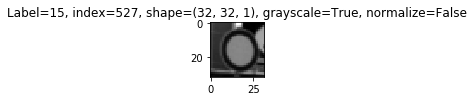

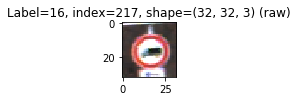

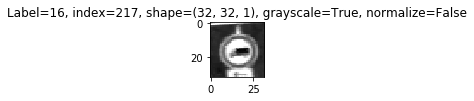

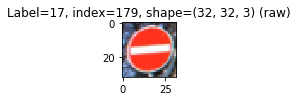

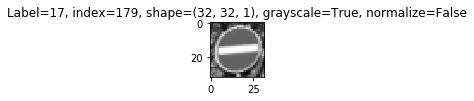

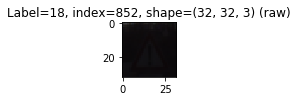

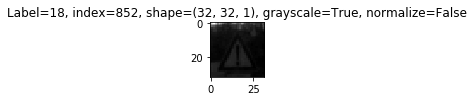

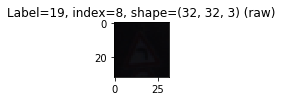

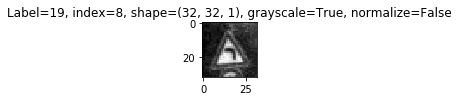

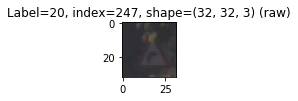

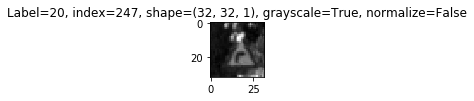

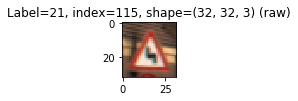

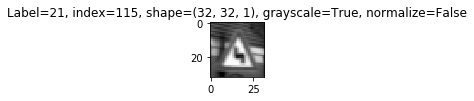

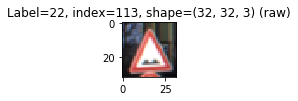

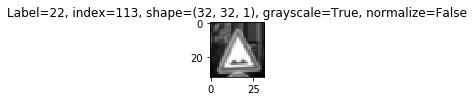

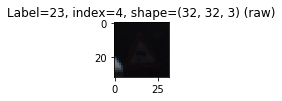

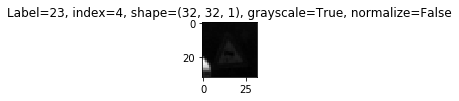

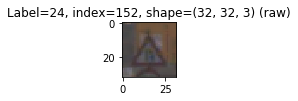

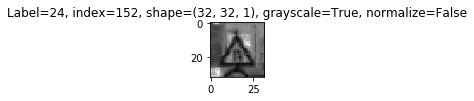

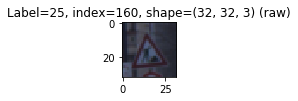

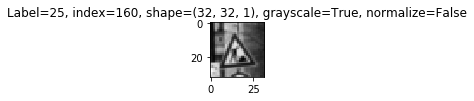

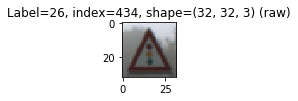

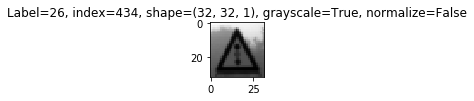

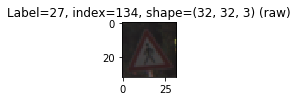

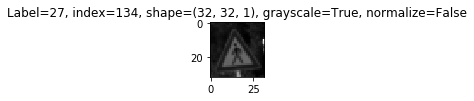

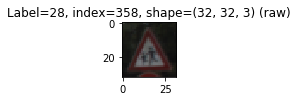

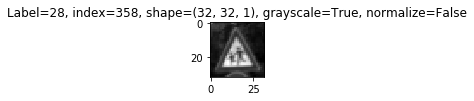

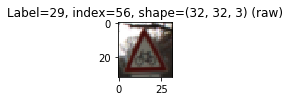

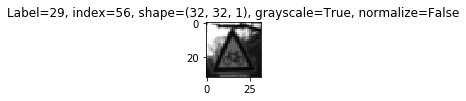

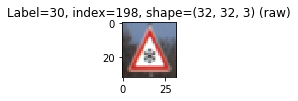

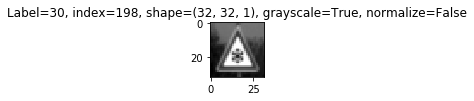

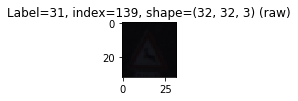

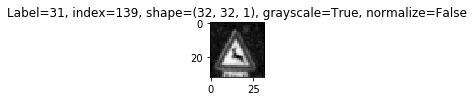

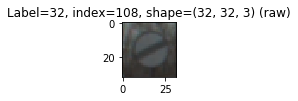

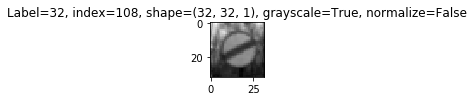

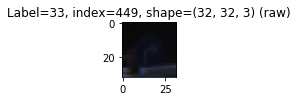

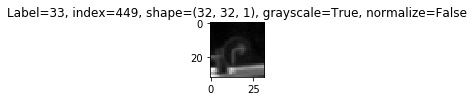

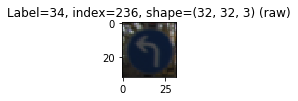

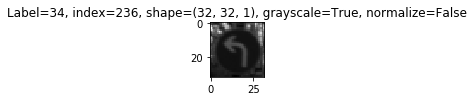

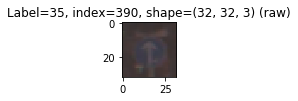

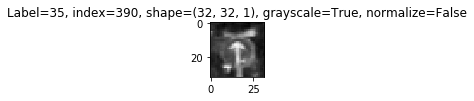

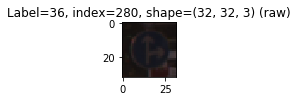

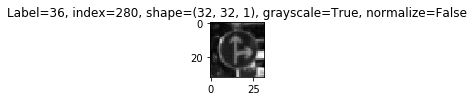

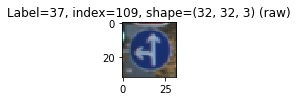

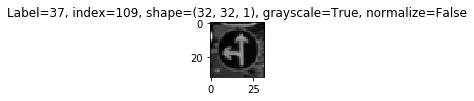

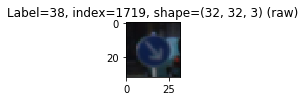

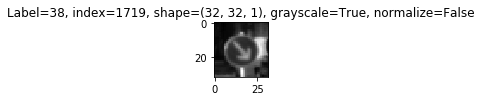

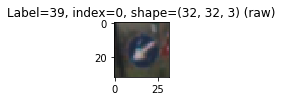

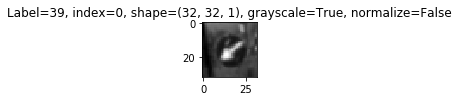

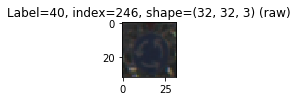

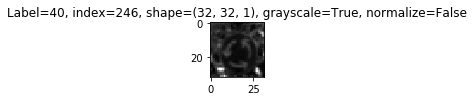

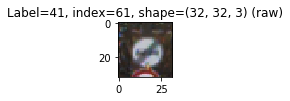

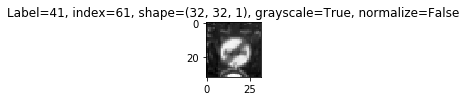

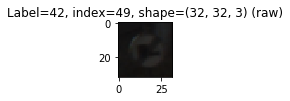

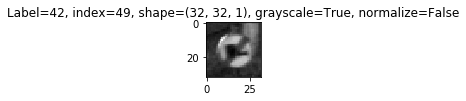

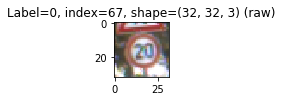

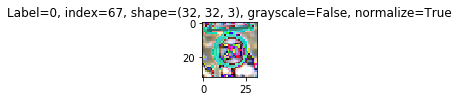

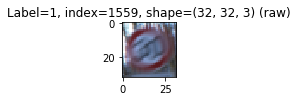

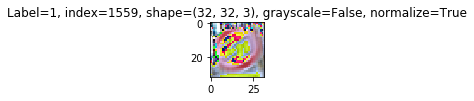

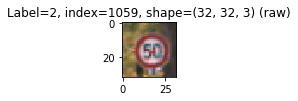

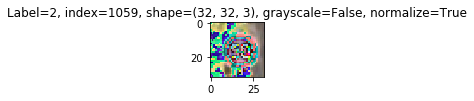

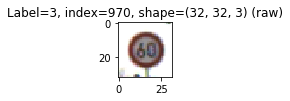

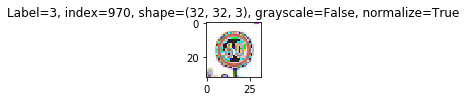

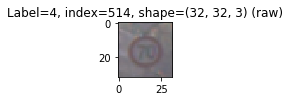

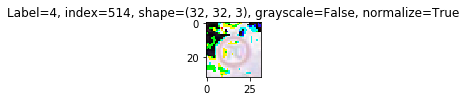

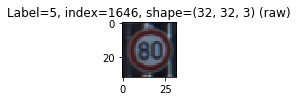

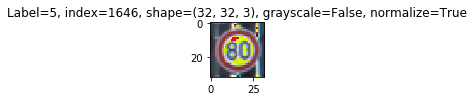

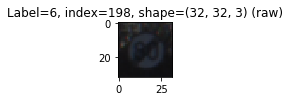

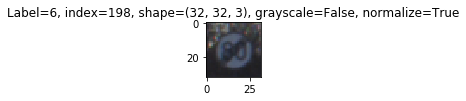

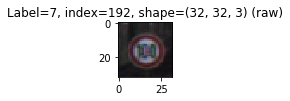

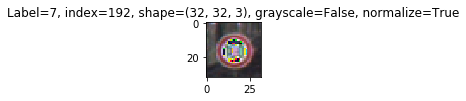

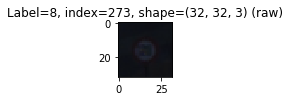

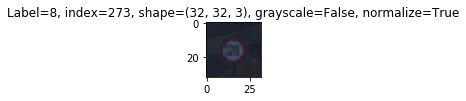

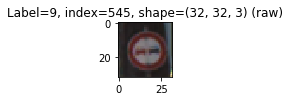

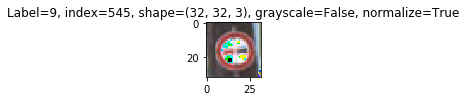

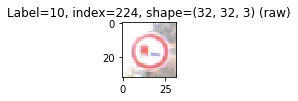

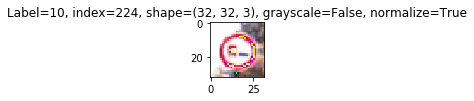

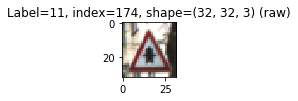

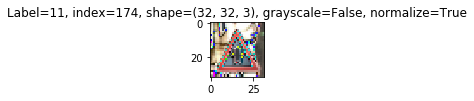

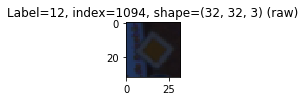

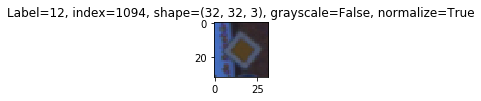

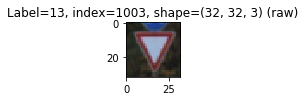

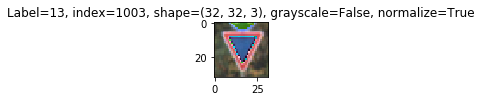

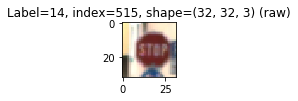

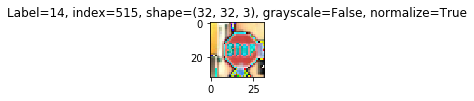

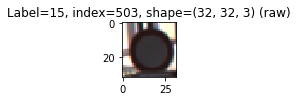

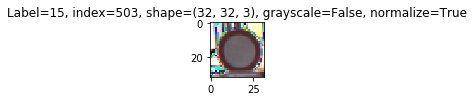

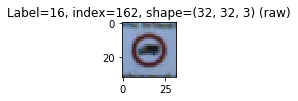

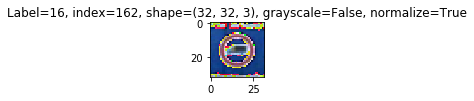

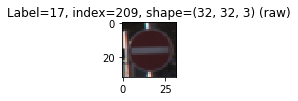

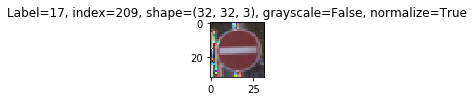

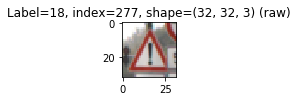

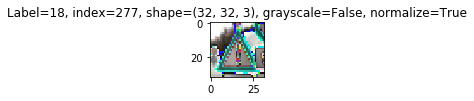

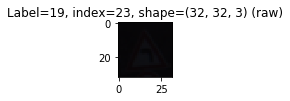

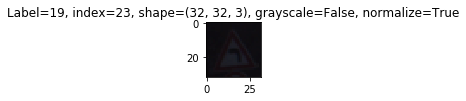

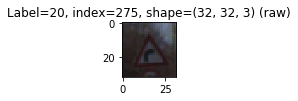

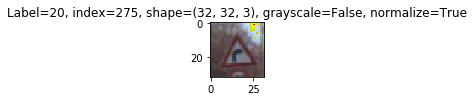

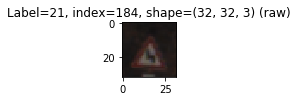

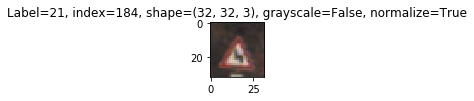

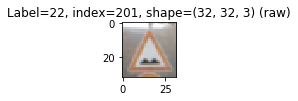

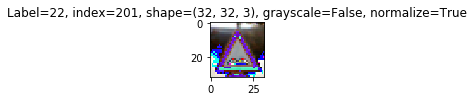

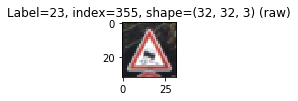

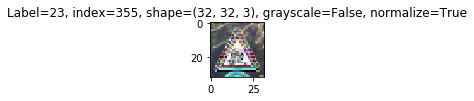

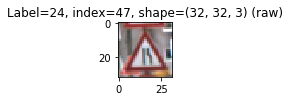

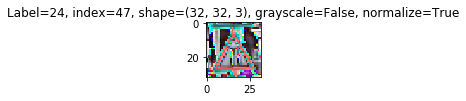

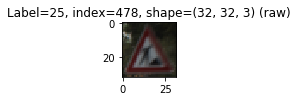

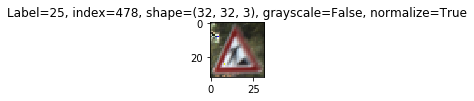

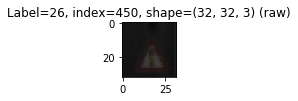

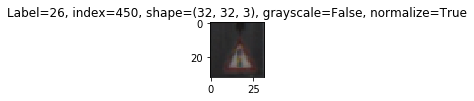

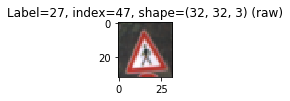

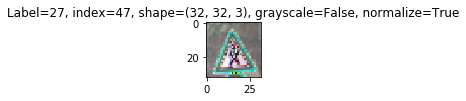

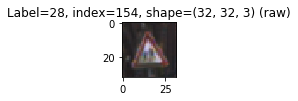

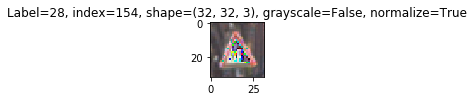

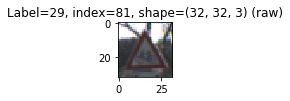

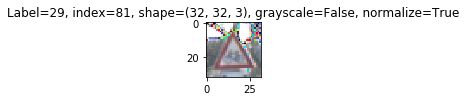

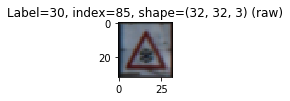

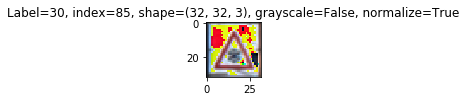

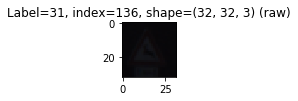

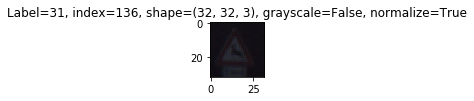

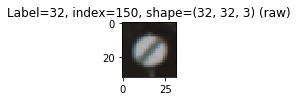

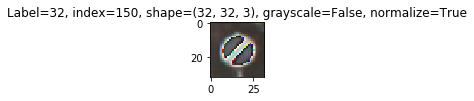

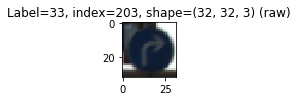

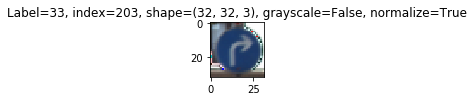

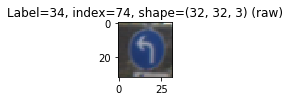

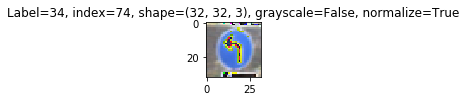

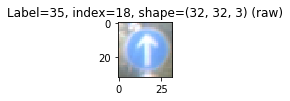

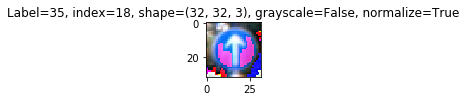

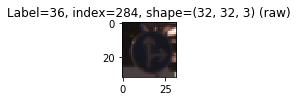

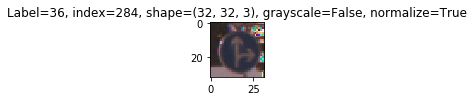

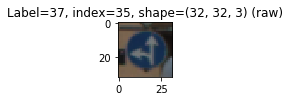

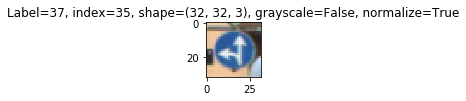

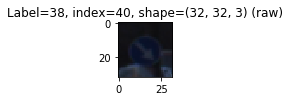

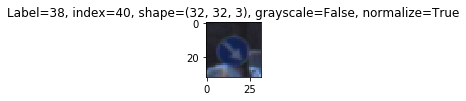

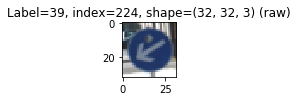

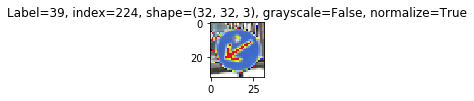

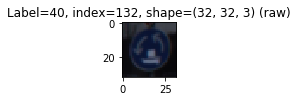

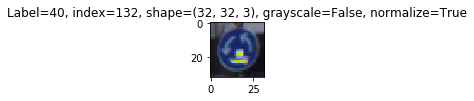

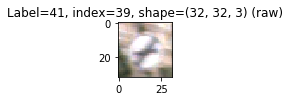

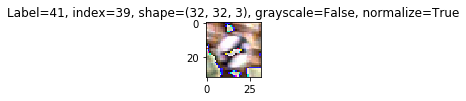

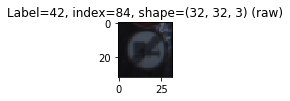

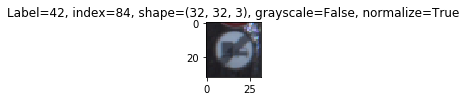

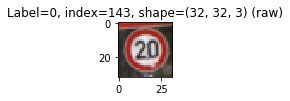

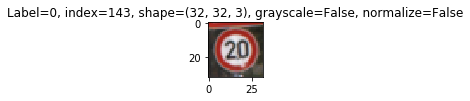

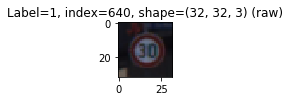

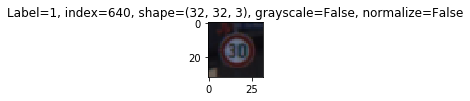

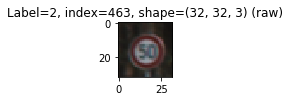

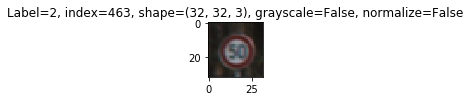

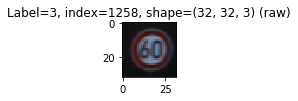

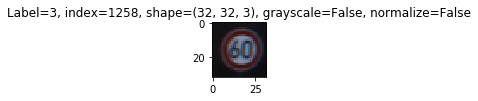

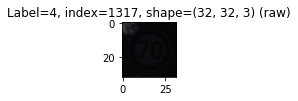

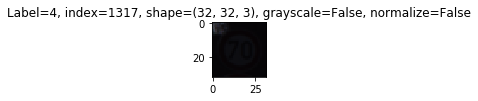

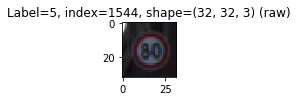

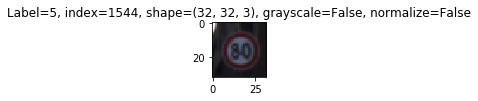

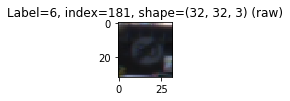

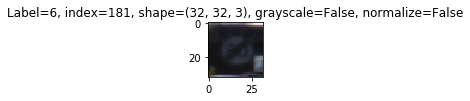

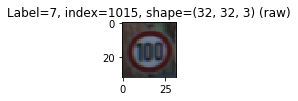

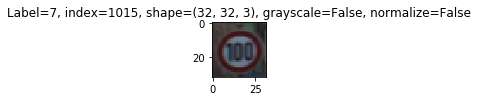

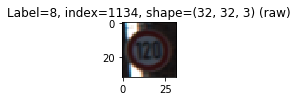

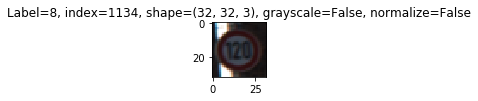

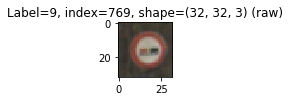

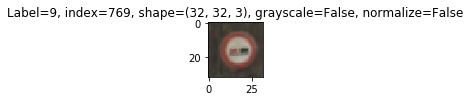

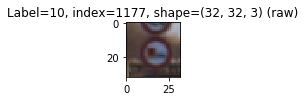

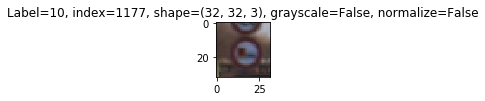

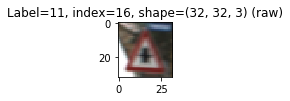

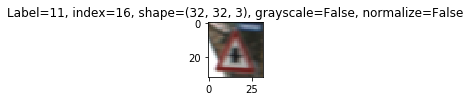

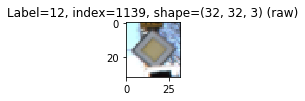

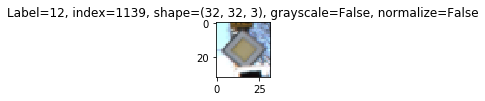

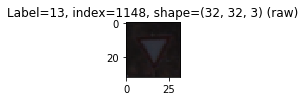

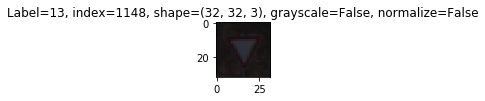

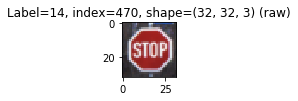

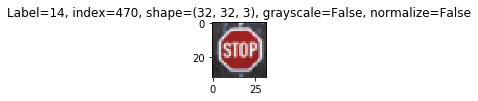

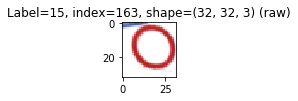

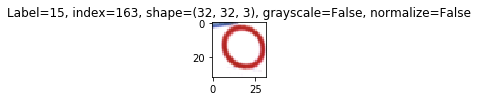

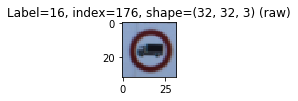

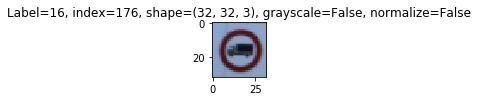

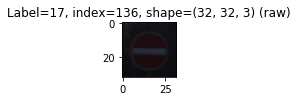

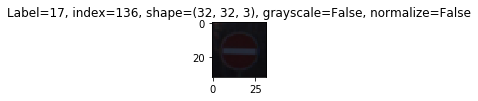

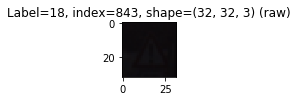

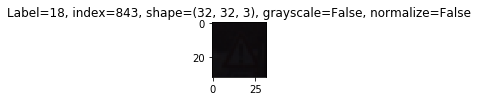

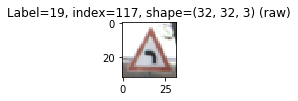

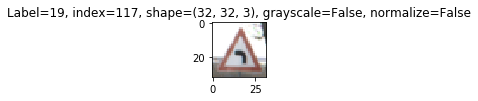

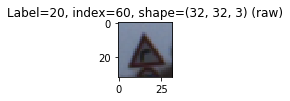

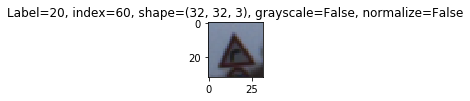

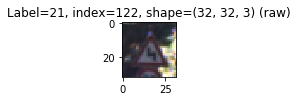

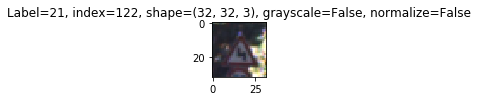

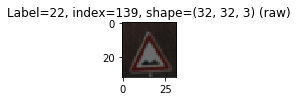

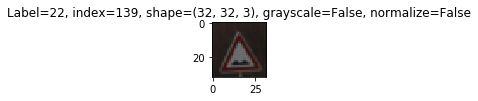

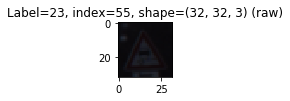

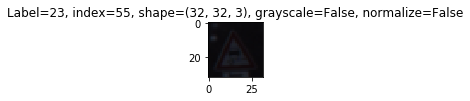

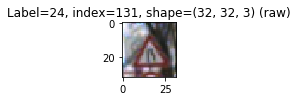

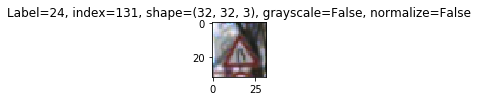

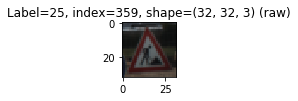

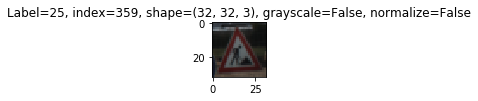

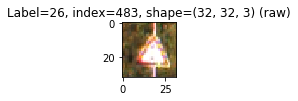

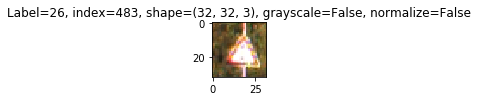

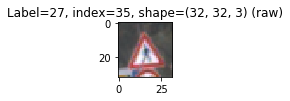

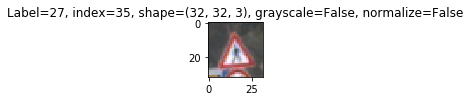

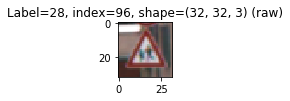

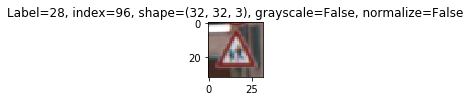

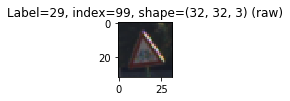

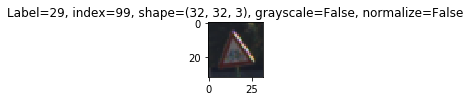

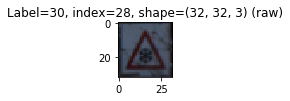

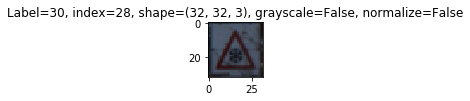

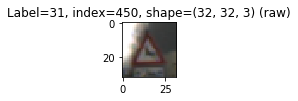

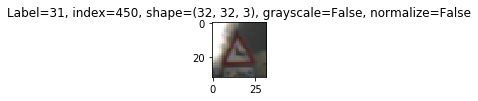

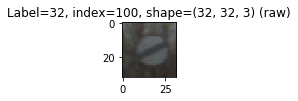

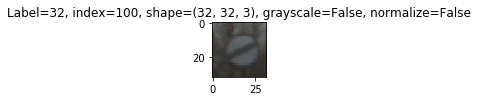

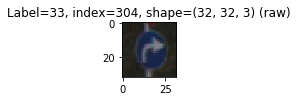

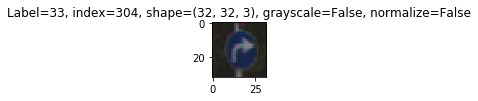

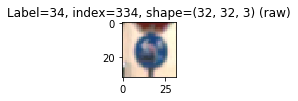

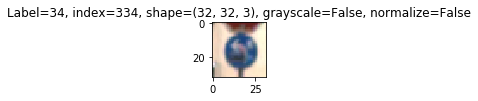

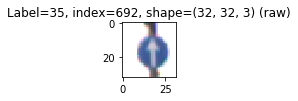

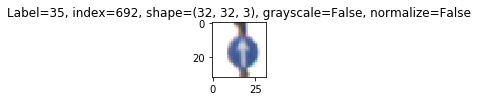

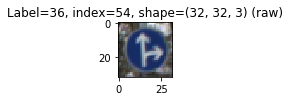

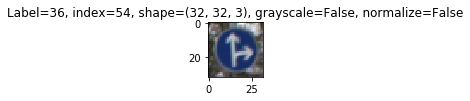

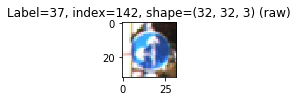

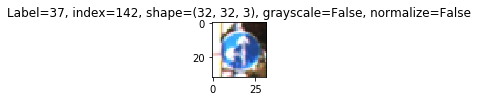

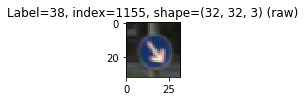

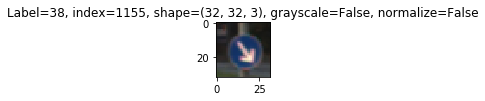

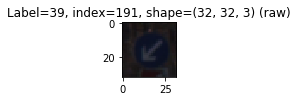

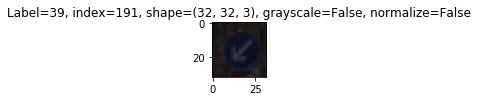

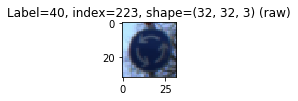

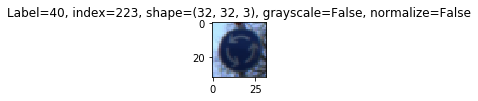

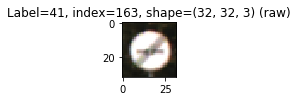

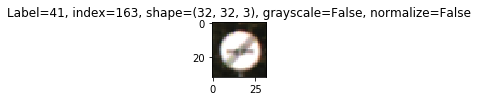

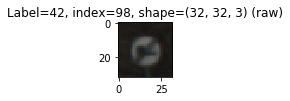

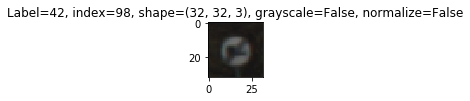

In [6]:
# visualize pre-processed samples
from itertools import product

all_config = list(product(np.array([True,False]),
                          np.array([True,False])))

for curr_config in all_config:
    curr_grayscale = curr_config[0]
    curr_normalize = curr_config[1]

    # build images to display
    X_train_pre,X_valid_pre,X_test_pre,image_depth_pre,image_width,image_height = \
        build_images(X_train,X_valid,X_test,curr_grayscale,curr_normalize)

    # find samples to display
    dict_train_pre = defaultdict(list)
    for key, value in zip(y_train,X_train_pre):
        dict_train_pre[key].append(value)

    # display raw/pre-processed samples
    for key, value_pre in dict_train_pre.items():
        value_raw = dict_train_raw[key]    
        index = random.randint(0, (min(len(value_raw),len(value_pre))-1))

        image_raw = value_raw[index]
        image_pre = value_pre[index]

        plt.figure(figsize=(1,1))
        plt.imshow(image_raw.squeeze(), cmap="gray")
        plt.title("Label={}, index={}, shape={} (raw)".format(key,index,image_raw.shape))

        plt.figure(figsize=(1,1))
        plt.imshow(image_pre.squeeze(), cmap="gray")
        plt.title("Label={}, index={}, shape={}, grayscale={}, normalize={}".format(key,index,image_pre.shape,curr_grayscale,curr_normalize))


---
## Step 4: Build Model / Architecture

Builds logits and feedback infrastructure. Also includes methods for training and evaluating the model using batched inputs.

I rebuild the model, every time so I may evaluate structural modifications (e.g., convlution layuer depth) as well as procedural hyperparameters (e.g., learning rate).

In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def build_logits(x,curr_keep,curr_mu,curr_sigma,curr_conv1_depth,curr_conv2_depth):    
    """ Builds logits hierarchy and returns key elements.
    """
    # Arguments used for tf.truncated_normal
    # randomly defines variables for the weights and biases for each layer
    keep = tf.placeholder_with_default(1.0,shape=(None), name="keep")
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = (variable).
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, image_depth_pre, curr_conv1_depth), 
                                              mean = curr_mu, stddev = curr_sigma), name="conv1_W")
    conv1_b = tf.Variable(tf.zeros(curr_conv1_depth), name="conv1_b")
    conv1   = tf.add(tf.nn.conv2d(x,conv1_W, strides=[1, 1, 1, 1], padding='VALID'),conv1_b)

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = (variable). Output = (variable).
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = (variable).
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, curr_conv1_depth, curr_conv2_depth), 
                                              mean = curr_mu, stddev = curr_sigma),name="conv2_W")
    conv2_b = tf.Variable(tf.zeros(curr_conv2_depth),name="conv2_b")
    conv2   = tf.add(tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID'),conv2_b)
    
    # Activation.
    conv2    = tf.nn.relu(conv2)
    # conv2    = tf.nn.dropout(conv2, curr_keep)

    # Pooling. Input = (variable). Output = (variable).
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = (variable). Output = (variable).
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = (variable). Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=((5*5*curr_conv2_depth), 120), 
                                              mean = curr_mu, stddev = curr_sigma),name="fc1_W")
    fc1_b = tf.Variable(tf.zeros(120),name="fc1_b")
    fc1   = tf.add(tf.matmul(fc0, fc1_W),fc1_b)
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    # fc1    = tf.nn.dropout(fc1, curr_keep)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), 
                                              mean = curr_mu, stddev = curr_sigma),name="fc2_W")
    fc2_b  = tf.Variable(tf.zeros(84),name="fc2_b")
    fc2    = tf.add(tf.matmul(fc1, fc2_W),fc2_b)
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), 
                                              mean = curr_mu, stddev = curr_sigma),name="fc3_W")
    fc3_b  = tf.Variable(tf.zeros(n_classes),name="fc3_b")
    logits = tf.add(tf.matmul(fc2, fc3_W),fc3_b)
    
    return logits, keep, [conv1,conv2,fc1,fc2]

In [8]:
def build_classifier(curr_keep,curr_mu,curr_sigma,curr_rate,curr_conv1_depth,curr_conv2_depth):
    """ Builds logits + feedback elements and returns key elements.
    """
    x_tensor = tf.placeholder(tf.float32, (None, image_width,image_height,image_depth_pre), name="x")
    y_tensor = tf.placeholder(tf.int32, (None), name="y")
    
    one_hot_y = tf.one_hot(y_tensor,n_classes)
    logits,keep_tensor,activation_layers = \
        build_logits(x_tensor,curr_keep,curr_mu,curr_sigma,curr_conv1_depth,curr_conv2_depth)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=curr_rate)
    
    training_operation = optimizer.minimize(loss_operation)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return x_tensor,y_tensor,logits,keep_tensor,activation_layers,training_operation,accuracy_operation

In [9]:
def train_classifier(x_tensor,y_tensor,keep_tensor,training_operation,X_data,y_data,curr_batch):
    """ Trains model.
    """
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0,num_examples,curr_batch):
        end = offset+curr_batch
        batch_x, batch_y = X_data[offset:end],y_data[offset:end]
        sess.run(training_operation, \
                 feed_dict={x_tensor:batch_x,y_tensor:batch_y,keep_tensor:curr_keep})

In [10]:
def evaluate_classifier(x_tensor,y_tensor,keep_tensor,accuracy_operation,X_data,y_data,curr_batch):
    """ Evaluates model.
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0,num_examples,curr_batch):
        end = offset+curr_batch
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation, \
                feed_dict={x_tensor:batch_x,y_tensor:batch_y,keep_tensor:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

---
## Step 5: Train & Evaluate vs Validation Set

Automates (a) building the model with a spread of key structural/procedural hyperparameters and (b) evaluating it, repetitively to isolate the best example.

In [11]:
from sklearn.utils import shuffle
from operator import itemgetter

default_mu = 0.0
default_sigma = 0.1
default_rate = 0.001
default_epochs = 10
default_keep = 0.5
default_batch_size = 128

# Initial values provided w/examples

# mu_range = np.array([default_mu])
# sigma_range = np.array([default_sigma])
# rate_range = np.array([default_rate])
# epochs_range = np.array([default_epochs])
# keep_range = np.array([default_keep])
# batch_size_range = np.array([default_batch_size])

# Best, single values found
# Note: Did ~2000 runs to find these, but
# I wager they're still not the best values.

found_mu = 0.0
found_sigma = 0.1
found_rate = 0.0013
found_epochs = 100
found_keep = 0.5
found_batch_size = 128
found_grayscale = True
found_normalize = True
found_conv1_depth = 24
found_conv2_depth = 64

mu_range = np.array([found_mu])
sigma_range = np.array([found_sigma])
rate_range = np.array([found_rate])
epochs_range = np.array([found_epochs])
keep_range = np.array([found_keep])
batch_size_range = np.array([found_batch_size])
grayscale_range = np.array([found_grayscale])
normalize_range = np.array([found_normalize])
conv1_depth_range = np.array([found_conv1_depth])
conv2_depth_range = np.array([found_conv2_depth])

# Ranges for searching (uncomment/modify to retry)
# Note: The _best_ hyperparameters may be isolated more
# practically w/reiterative sampling (i.e., simulated annealing).

# mu_range = np.arange(-10.0,11.0,10.0)
# sigma_range = np.arange(0.1,1.0,0.4)
# rate_range = np.arange(0.0007,0.0014,0.0003)
# epochs_range = np.arange(10,41,15)
# keep_range = np.arange(0.5,1.1,0.25)
# batch_size_range = np.arange(64,193,64)
# grayscale_range = np.array([True,False])
# normalize_range = np.array([True,False])
# conv1_depth_range = np.array([6,16,24])
# conv2_depth_range = np.array([16,40,64])

best_accuracy = 0.0
best_epochs = 0

# product = all, relevant permutations of parameters
all_config = list(product(mu_range,sigma_range,
                            rate_range,epochs_range,
                            keep_range,batch_size_range,
                            grayscale_range,normalize_range,
                            conv1_depth_range,conv2_depth_range))
all_accuracy = []
all_work_config = []

n_tries = 3
n_permutations=len(all_config)
n_passes = (n_tries*n_permutations)
pass_ctr = 0
print ('Total passes {} (tries={}, permutations={}):'.format(n_passes,n_tries,n_permutations))

# iterate several times (stochastic approach)
for curr_try in range(n_tries):
    # shuffle, because obsessive :)
    random.shuffle(all_config)
    for curr_config in all_config:
        # mutable version of config so we can capture 
        # epoch count before degredation
        work_config = list(curr_config)

        curr_mu = work_config[0]
        curr_sigma = work_config[1]
        curr_rate = work_config[2]
        curr_epochs = work_config[3]
        curr_keep = work_config[4]
        curr_batch_size = work_config[5]
        curr_grayscale = work_config[6]
        curr_normalize = work_config[7]
        curr_conv1_depth = work_config[8]
        curr_conv2_depth = work_config[9]

        # reset, rebuild
        tf.reset_default_graph()
        X_train_pre,X_valid_pre,X_test_pre,image_depth_pre,image_width,image_height = \
            build_images(X_train,X_valid,X_test,curr_grayscale,curr_normalize)
        y_train_pre = np.copy(y_train)
        y_valid_pre = np.copy(y_valid)
        y_test_pre = np.copy(y_test)
        
        x_tensor,y_tensor,logits,keep_tensor,activation_layers,training_operation,accuracy_operation = \
            build_classifier(curr_keep,curr_mu,curr_sigma,curr_rate,curr_conv1_depth,curr_conv2_depth)
        saver = tf.train.Saver()
        
        # train, validate
        with tf.Session() as sess:
            pass_ctr = (pass_ctr+1)

            max_accuracy = 0.0
            max_accuracy_epochs = 0
            curr_accuracy = 0.0
            bad_accuracy_ctr = 0
            max_bad_accuracy = max(5,(curr_epochs/5))

            print("Current pass #", pass_ctr, "of", n_passes)
            print("    curr_mu: ", curr_mu)
            print("    curr_sigma: ", curr_sigma)
            print("    curr_rate: ", curr_rate)
            print("    curr_epochs: ", curr_epochs)
            print("    curr_keep: ", curr_keep)
            print("    curr_batch_size: ", curr_batch_size)
            print("    curr_grayscale: ", curr_grayscale)
            print("    curr_normalize: ", curr_normalize)
            print("    curr_conv1_depth: ", curr_conv1_depth)
            print("    curr_conv2_depth: ", curr_conv2_depth)

            sess.run(tf.global_variables_initializer())
            for i in range(curr_epochs):
                # shuffle & train
                X_train_pre,y_train_pre = shuffle(X_train_pre,y_train_pre)
                train_classifier(x_tensor,y_tensor,keep_tensor,training_operation,X_train_pre,y_train_pre,curr_batch_size)

                # evaulate vs known values
                X_valid_pre,y_valid_pre = shuffle(X_valid_pre,y_valid_pre)
                curr_accuracy = evaluate_classifier(x_tensor,y_tensor,keep_tensor,accuracy_operation,X_valid_pre,y_valid_pre,curr_batch_size)

                # checkpoint the best accuracy at peak epoch
                if curr_accuracy > best_accuracy or \
                    (curr_accuracy == best_accuracy and i < best_epochs):
                        # track best
                        best_accuracy = curr_accuracy
                        best_epochs = i

                        # save best
                        saver.save(sess, './lenet')

                # check for early degredation/termination
                if curr_accuracy < max_accuracy:
                    bad_accuracy_ctr = (bad_accuracy_ctr+1)
                    if bad_accuracy_ctr > max_bad_accuracy:
                        print("Stopping at epoch #", i, "(degrading accuracy)!")
                        break
                else:
                    bad_accuracy_ctr = 0
                    max_accuracy = max(max_accuracy,curr_accuracy)
                    max_accuracy_epochs = i

            # update config w/actual epochs
            work_config[3] = max_accuracy_epochs

            # track
            all_accuracy.append(max_accuracy)
            all_work_config.append(work_config)

            print("Accuracy (Validation) = {:.3f}".format(max_accuracy))
            print ()

# sort & report best results 
# (possible to see duplicates due to repetition)
sorted_output = \
    [list(x) for x in zip(*sorted(zip(all_accuracy, all_work_config), key=itemgetter(0), reverse=True))] 
max_output = min(10,len(sorted_output[0]))
    
print ("Top", max_output, "results:")
for index in range(0,max_output):
    print ("Accuracy = {:.3f}".format(sorted_output[0][index]),"/ Config =",sorted_output[1][index])


Total passes 3 (tries=3, permutations=1):
Current pass # 1 of 3
    curr_mu:  0.0
    curr_sigma:  0.1
    curr_rate:  0.0013
    curr_epochs:  100
    curr_keep:  0.5
    curr_batch_size:  128
    curr_grayscale:  True
    curr_normalize:  True
    curr_conv1_depth:  24
    curr_conv2_depth:  64
Stopping at epoch # 43 (degrading accuracy)!
Accuracy (Validation) = 0.975

Current pass # 2 of 3
    curr_mu:  0.0
    curr_sigma:  0.1
    curr_rate:  0.0013
    curr_epochs:  100
    curr_keep:  0.5
    curr_batch_size:  128
    curr_grayscale:  True
    curr_normalize:  True
    curr_conv1_depth:  24
    curr_conv2_depth:  64
Stopping at epoch # 29 (degrading accuracy)!
Accuracy (Validation) = 0.970

Current pass # 3 of 3
    curr_mu:  0.0
    curr_sigma:  0.1
    curr_rate:  0.0013
    curr_epochs:  100
    curr_keep:  0.5
    curr_batch_size:  128
    curr_grayscale:  True
    curr_normalize:  True
    curr_conv1_depth:  24
    curr_conv2_depth:  64
Stopping at epoch # 88 (degrading accu

---
## Step 6: Evaluate vs Test Set

Evaluate the best, trained model vs a provided test set of images.

In [12]:
# reset, rebuild
X_train_pre,X_valid_pre,X_test_pre,image_depth_pre,image_width,image_height = \
    build_images(X_train,X_valid,X_test,found_grayscale,found_normalize)
y_train_pre = np.copy(y_train)
y_valid_pre = np.copy(y_valid)
y_test_pre = np.copy(y_test)

tf.reset_default_graph()
x_tensor,y_tensor,logits,keep_tensor,activation_layers,training_operation,accuracy_operation = \
    build_classifier(found_keep,found_mu,found_sigma,found_rate,found_conv1_depth,found_conv2_depth)

# test
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, './lenet')

    X_test_pre,y_test_pre = shuffle(X_test_pre, y_test_pre)
    test_accuracy = evaluate_classifier(x_tensor,y_tensor,keep_tensor,accuracy_operation,X_test_pre,y_test_pre,found_batch_size)

    print("Accuracy (Test) =", test_accuracy)

Accuracy (Test) = 0.950673000641


---
## Step 7: Load / Display New Images

Load and pre-process ad hoc images taken from Google Street View in/around Düsseldorf

input_data/real_signs/label-17.png = (32, 32, 3)
input_data/real_signs/label-7.png = (32, 32, 3)
input_data/real_signs/label-13.png = (32, 32, 3)
input_data/real_signs/label-35.png = (32, 32, 3)
input_data/real_signs/label-1.png = (32, 32, 3)
input_data/real_signs/label-5.png = (32, 32, 3)
input_data/real_signs/label-2.png = (32, 32, 3)
input_data/real_signs/label-22.png = (32, 32, 3)
input_data/real_signs/label-33.png = (32, 32, 3)
input_data/real_signs/label-25.png = (32, 32, 3)


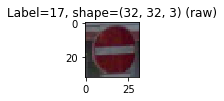

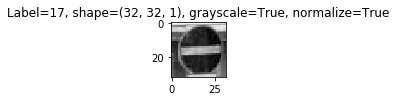

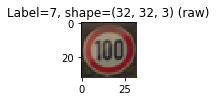

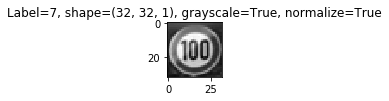

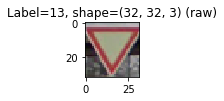

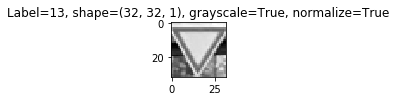

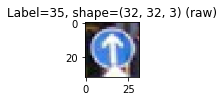

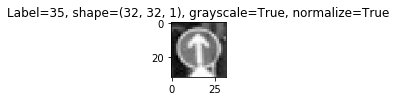

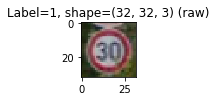

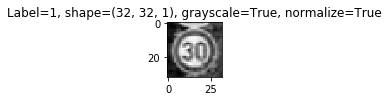

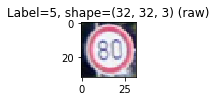

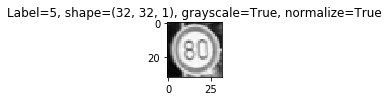

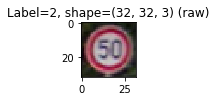

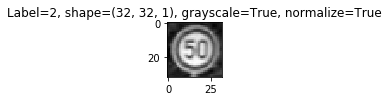

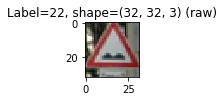

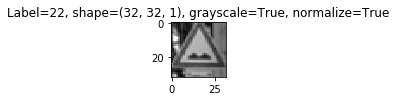

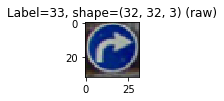

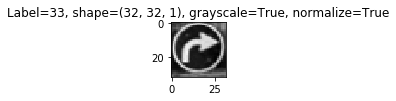

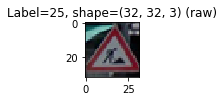

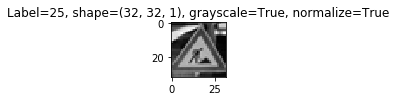

In [13]:
import glob
import os
import re
import matplotlib.pyplot as plt
import cv2

X_real = []
y_real = []

# load from disk & label using filenames
# (won't work with duplicate labels w/o extra serial number)
for image_file in glob.glob("input_data/real_signs/label-*.png"):
    file_parts = re.split("-|\.",os.path.basename(image_file))
    image_data = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    image_label = int(file_parts[1])
    
    print (image_file, "=", image_data.shape)
    X_real.append(image_data)
    y_real.append(image_label)

# pre-process, like others
X_real_pre = pre_process_images(np.array(X_real),found_grayscale,found_normalize)
y_real_pre = np.array(y_real)

# visualize samples
for index in range(min(len(X_real),len(y_real))):
    key = y_real[index]
    image_raw = X_real[index]
    image_pre = X_real_pre[index]
    
    plt.figure(figsize=(1,1))
    plt.imshow(image_raw.squeeze(), cmap="gray")
    plt.title("Label={}, shape={} (raw)".format(key,image_raw.shape))

    plt.figure(figsize=(1,1))
    plt.imshow(image_pre.squeeze(), cmap="gray")
    plt.title("Label={}, shape={}, grayscale={}, normalize={}".format(key,image_pre.shape,found_grayscale,found_normalize))

# shuffle, because obsessive :)
X_real_pre, y_real_pre = shuffle(X_real_pre, y_real_pre)


---
## Step 8: Evaluate vs New Images / Analyze Performance

Evaluate the best, trained model vs above images, the analyze performance by printing/plotting label prediction for each.

Accuracy (Real) = 0.900


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


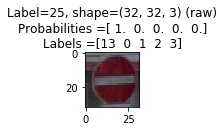

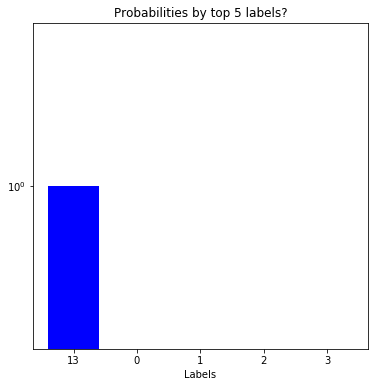

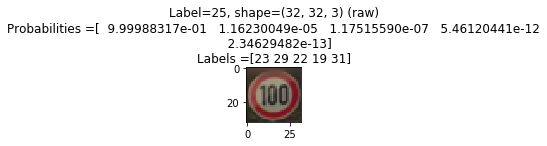

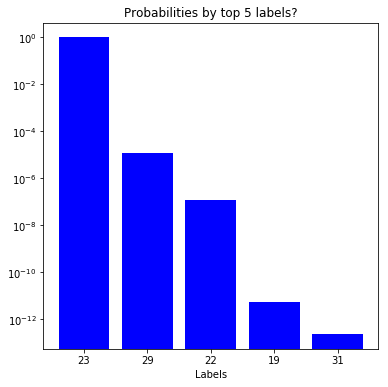

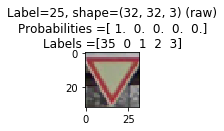

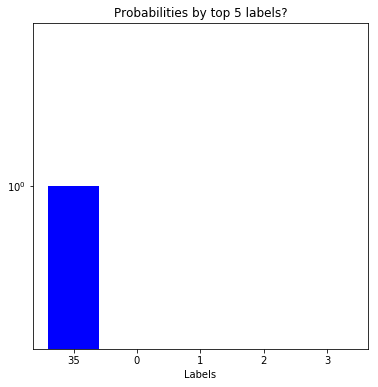

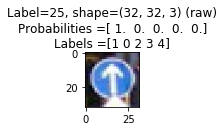

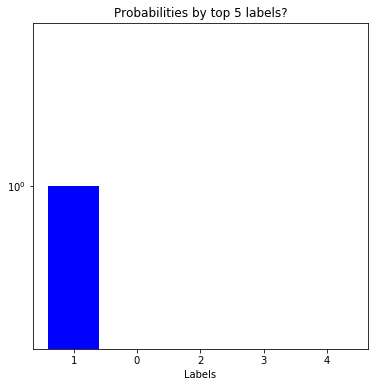

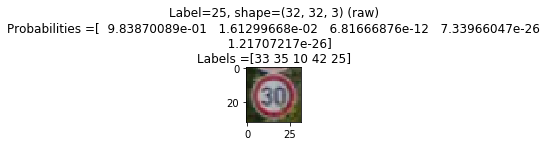

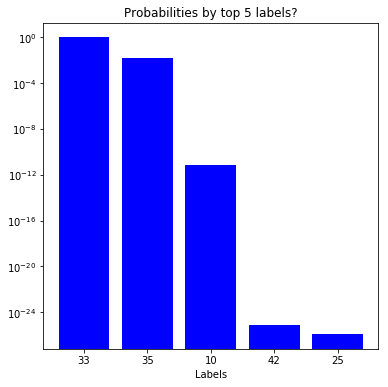

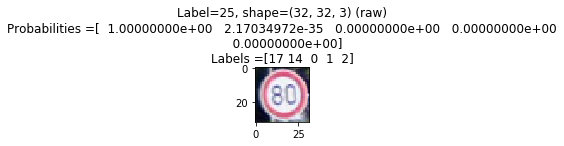

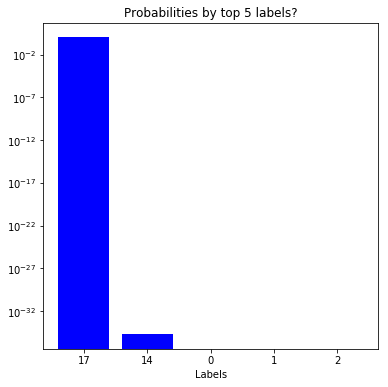

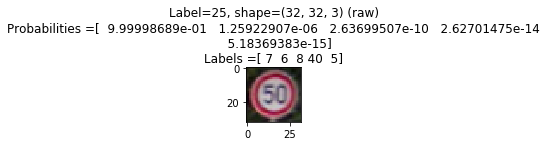

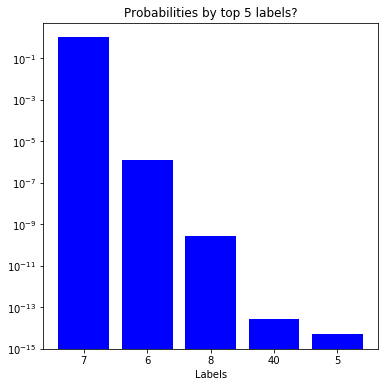

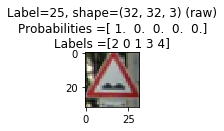

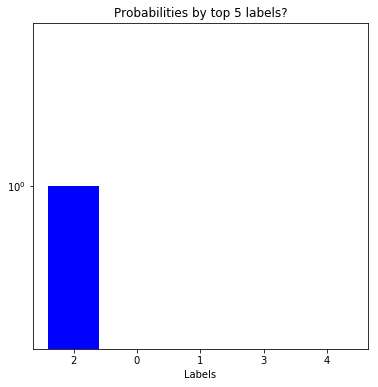

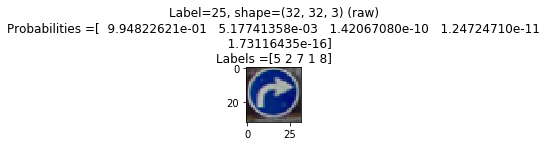

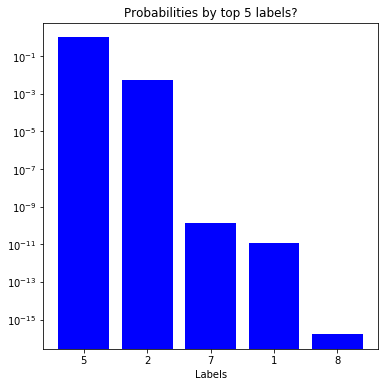

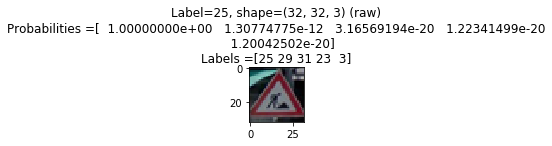

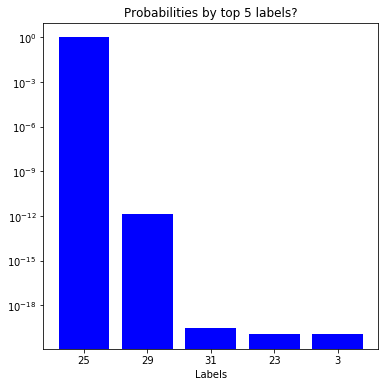

In [14]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
tf.reset_default_graph()
x_tensor,y_tensor,logits,keep_tensor,activation_layers,training_operation,accuracy_operation = \
    build_classifier(found_keep,found_mu,found_sigma,found_rate,found_conv1_depth,found_conv2_depth)
softmax = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, './lenet')

    X_real_pre,y_real_pre = shuffle(X_real_pre,y_real_pre)
    real_probability = sess.run(softmax, \
                        feed_dict={x_tensor:X_real_pre,y_tensor:y_real_pre,keep_tensor:1.0})
    real_top_k = sess.run(tf.nn.top_k(tf.constant(real_probability),5), \
                        feed_dict={x_tensor:X_real_pre,y_tensor:y_real_pre,keep_tensor:1.0})
    
    real_accuracy = evaluate_classifier(x_tensor,y_tensor,keep_tensor,accuracy_operation,X_real_pre,y_real_pre,found_batch_size)
    print("Accuracy (Real) = {:.3f}".format(real_accuracy))

for index in range(min(len(X_real),len(y_real))):
    real_label = y_real[index]
    real_image = X_real[index]
    
    found_probabilities = real_top_k.values[index]
    found_labels = real_top_k.indices[index]
    
    plt.figure(figsize=(1,1))
    plt.imshow(real_image.squeeze(), cmap="gray")
    plt.title("Label={}, shape={} (raw)".format(key,real_image.shape) + "\n" \
            + "Probabilities =" + str(found_probabilities) + "\n" \
            + "Labels =" + str(found_labels))
    
    fig,ax = plt.subplots(figsize=(6, 6))
    ax.bar(np.arange(len(found_probabilities)), found_probabilities, align='center', 
            color='blue', ecolor='black')
    ax.set_xticks(np.arange(len(found_labels)))
    ax.set_xticklabels(found_labels)
    ax.set_yscale('log')
    ax.set_xlabel('Labels')
    ax.set_title('Probabilities by top 5 labels?')

    plt.show()



---
## Step 9: Visualize Working State

Visualizes an activation layer's working state (i.e., meta-imagery).

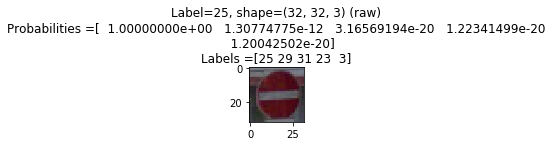

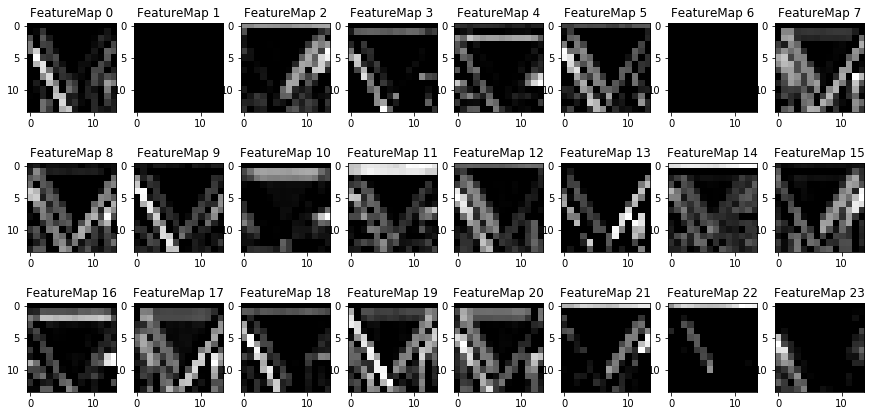

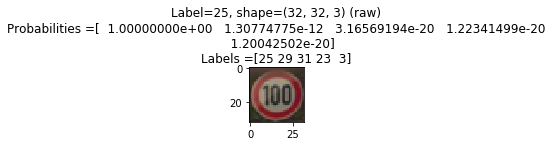

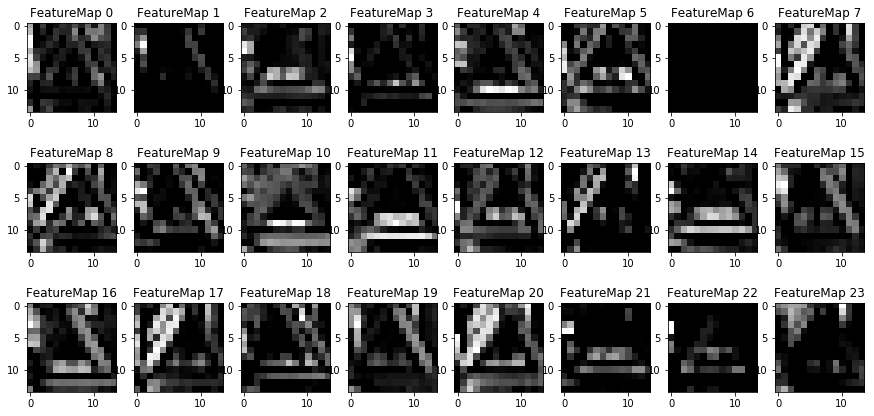

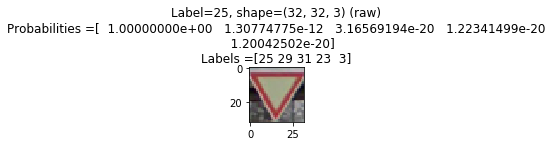

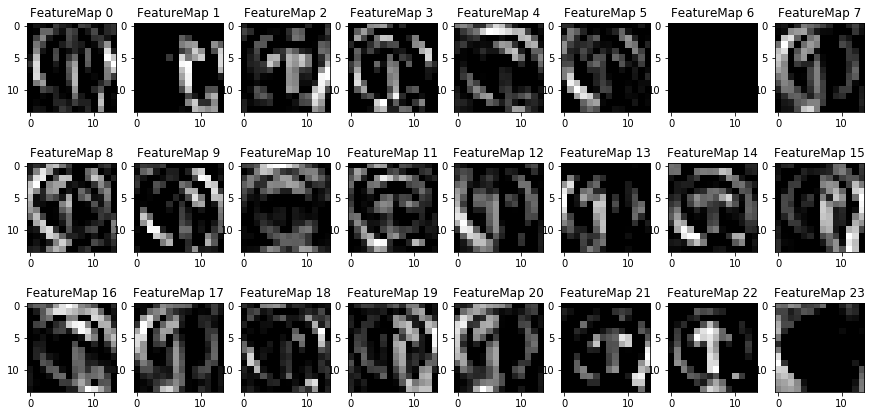

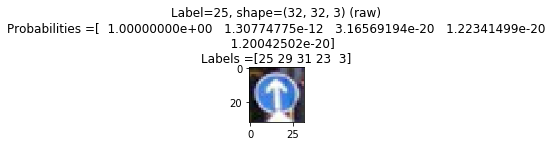

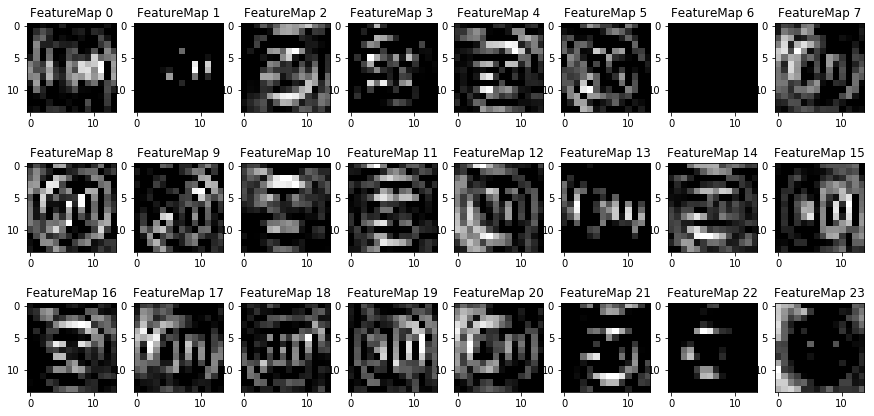

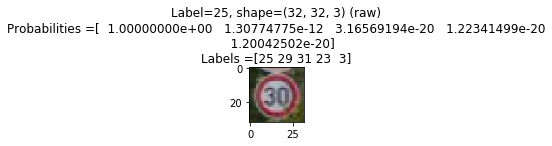

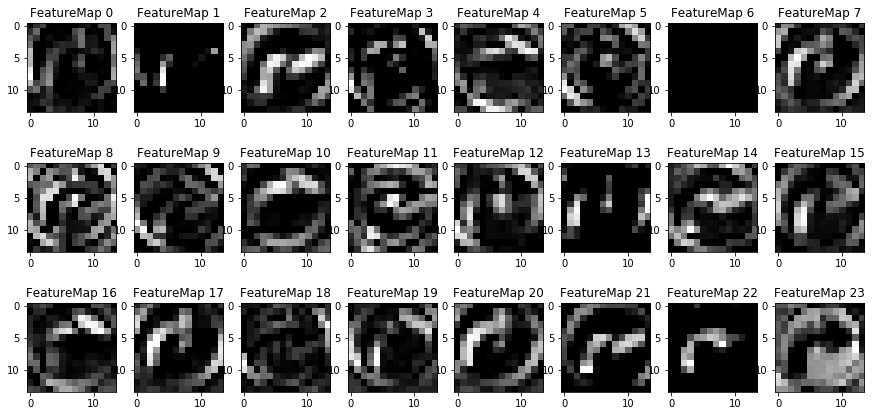

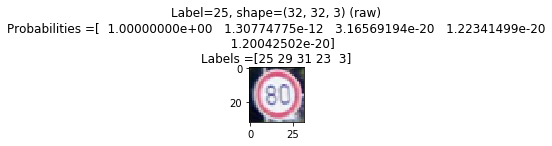

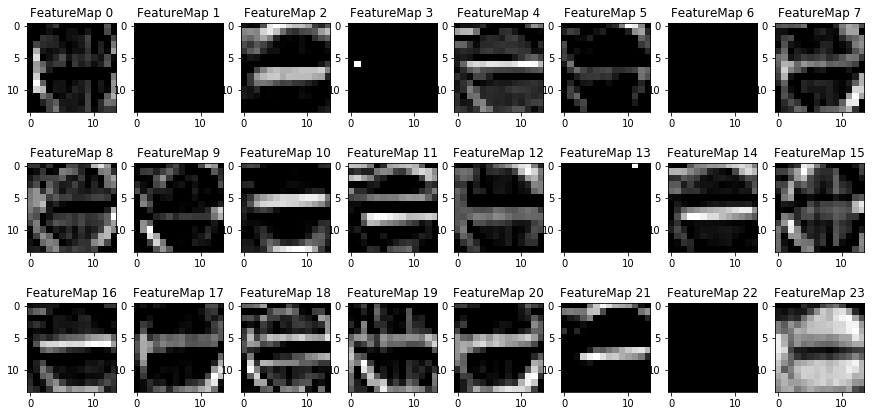

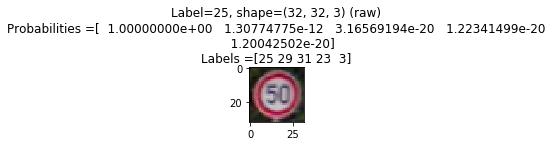

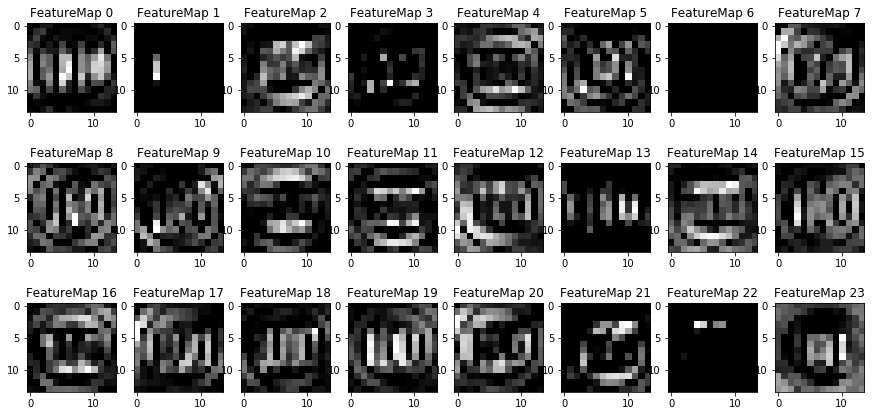

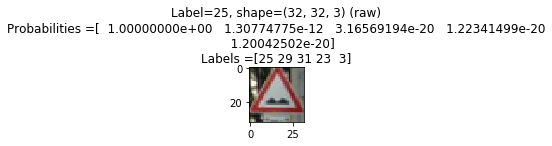

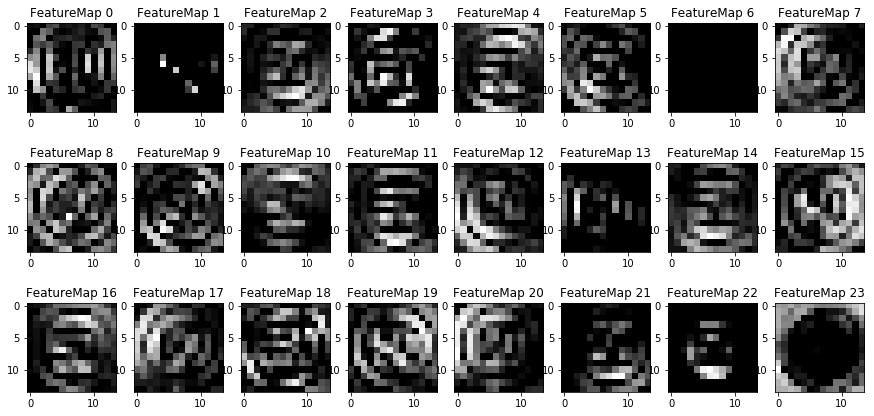

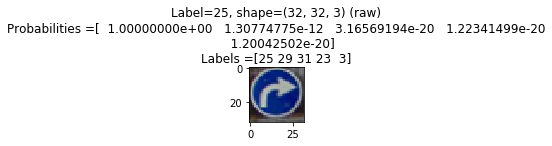

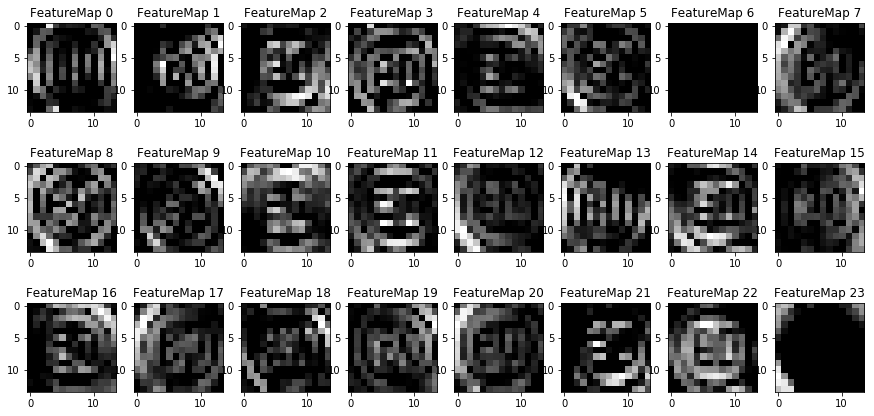

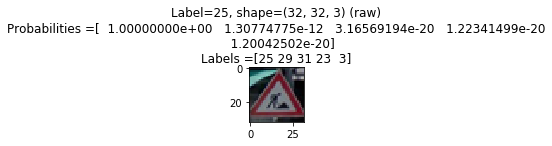

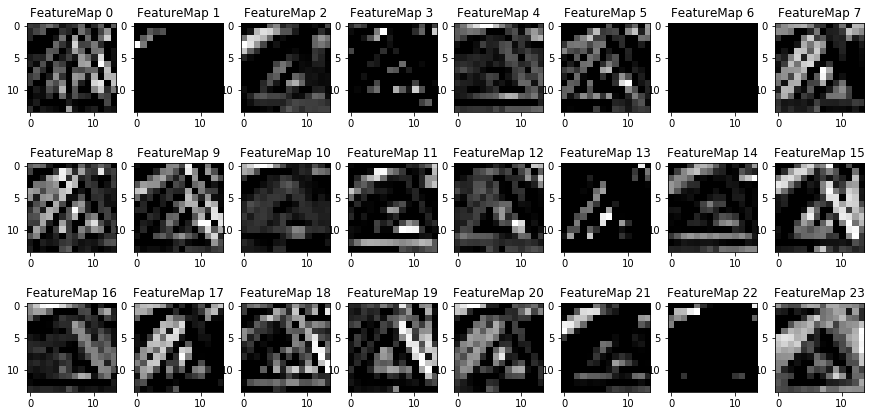

In [15]:
# plots images for a given activation layer
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = tf_activation.eval(session=sess,feed_dict={x_tensor : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

# loads best model, plots images
with tf.Session() as sess:
    for index in range(len(X_real)):
        saver = tf.train.Saver()
        saver.restore(sess, './lenet')

        real_label = y_real[index]
        real_image = X_real[index]
        real_image_pre = X_real_pre[index]

        plt.figure(figsize=(1,1))
        plt.imshow(real_image.squeeze(), cmap="gray")
        plt.title("Label={}, shape={} (raw)".format(key,real_image.shape) + "\n" \
                + "Probabilities =" + str(found_probabilities) + "\n" \
                + "Labels =" + str(found_labels))

        plt.show()
        outputFeatureMap(np.expand_dims(real_image_pre,0), activation_layers[0], activation_min=-1, activation_max=-1 ,plt_num=1)
